In [1]:
#### Import packages!!!
#import Pkg
#Pkg.add("Plots")
using Plots
#Pkg.add("BenchmarkTools")
using BenchmarkTools
#Pkg.add("Flux")
using Flux
#Pkg.add("CSV")
using CSV
#Pkg.add("DelimitedFiles")
using DelimitedFiles
#Pkg.add("Statistics")
using Statistics
#Pkg.add("BSON")
using BSON: @save
using BSON: @load
#Pkg.add("Random")
using Random
#Pkg.add("CUDA")
using CUDA

In [2]:
vel_GEOS_Array = readdlm( "Vel_GEOS_Jan_2019_NASA_GMAO_4x_4x.csv", ',', Float32);
scalar_GEOS_Array = readdlm("VL_GEOS_Jan_2019_NASA_GMAO_4x_4x.csv", ',', Float32);
xdim = size(vel_GEOS_Array, 1);
nstep = size(vel_GEOS_Array, 2);

In [3]:
Random.seed!(1)
history = (scalar_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel_GEOS_Array/15);

In [4]:
#### Programming advection scheme: from pgm1.f90
function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    s1_bc = zeros(xdim_total+2)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 3))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2]), xdim_total, 3)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [5]:
function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 3))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2]), xdim_total, 3)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [6]:
#### Programming advection scheme with 5 stencil
function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    s1_bc = zeros(xdim_total+4)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 5))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4]), xdim_total, 5)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [41]:
### Integrate function with 5 stencil
function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 5))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4]), xdim_total, 5)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [69]:
#### Programming advection scheme with 7 stencil
function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    #s1_bc = zeros(xdim_total+4)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 7))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6]), xdim_total, 7)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [119]:
### Integrate function with 7 stencil
function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 7))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6]), xdim_total, 7)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [77]:
#### Programming advection scheme with 13 stencil
function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    #s1_bc = zeros(xdim_total+4)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 13))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12]), xdim_total, 13)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [146]:
### Integrate function with 13 stencil
function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 13))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12]), xdim_total, 13)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [177]:
#### Programming advection scheme with 25 stencil
function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    #s1_bc = zeros(xdim_total+4)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 25))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], 
                [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12],
                [s1_bc[i] for i in 14:xdim_total+13],
                [s1_bc[i] for i in 15:xdim_total+14],
                [s1_bc[i] for i in 16:xdim_total+15],
                [s1_bc[i] for i in 17:xdim_total+16],
                [s1_bc[i] for i in 18:xdim_total+17],
                [s1_bc[i] for i in 19:xdim_total+18],
                [s1_bc[i] for i in 20:xdim_total+19],
                [s1_bc[i] for i in 21:xdim_total+20],
                [s1_bc[i] for i in 22:xdim_total+21],
                [s1_bc[i] for i in 23:xdim_total+22],
                [s1_bc[i] for i in 24:xdim_total+23],
                [s1_bc[i] for i in 25:xdim_total+24]), xdim_total, 25)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [178]:
### Integrate function with 25 stencil
function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 25))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], 
                [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12],
                [s1_bc[i] for i in 14:xdim_total+13],
                [s1_bc[i] for i in 15:xdim_total+14],
                [s1_bc[i] for i in 16:xdim_total+15],
                [s1_bc[i] for i in 17:xdim_total+16],
                [s1_bc[i] for i in 18:xdim_total+17],
                [s1_bc[i] for i in 19:xdim_total+18],
                [s1_bc[i] for i in 20:xdim_total+19],
                [s1_bc[i] for i in 21:xdim_total+20],
                [s1_bc[i] for i in 22:xdim_total+21],
                [s1_bc[i] for i in 23:xdim_total+22],
                [s1_bc[i] for i in 24:xdim_total+23],
                [s1_bc[i] for i in 25:xdim_total+24]), xdim_total, 25)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [5]:
input_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
u_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
target_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)

input_NN_integrate[:,1,1,:] = history[1][:,1:nstep-1]
u_NN_integrate[:,1,1,:] = history[2][:,1:nstep-1]
target_NN_integrate[:,1,1,:] = history[1][:,2:nstep]

#input_NN_integrate |> gpu
#u_NN_integrate |> gpu
#target_NN_integrate |> gpu

println("Good")

Good


In [23]:
model = Chain( Conv((3,), 2 => 32, pad = SamePad(), gelu),
    Conv((3,), 32 => 32, pad = SamePad(), gelu),
    Conv((3,), 32 => 6, pad = SamePad(), tanh))

loss(x, y) = Flux.Losses.mae(model(x), y)

ps = Flux.params(model)

Params([[0.101032585 -0.06463355; -0.24141769 -0.11077732; -0.12930311 0.215526;;; 0.07866518 0.16023567; -0.018893508 -0.049128782; 0.1258662 0.035474103;;; 0.15003097 -0.18678382; -0.15685987 0.09214957; -0.013927671 -0.11110272;;; … ;;; 0.17357226 0.22468129; 0.0572159 -0.22088891; 0.17641245 0.04513085;;; -0.23043643 -0.14968322; 0.18923944 0.010211894; -0.13237697 -0.015199301;;; 0.17831208 -0.11166594; -0.19571827 -0.075504385; -0.17519037 0.016309107], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.031345855 0.046344128 … -0.06702293 0.028874552; 0.04820299 -0.019757915 … 0.01469629 0.059738122; -0.06278399 0.1450521 … -0.151989 -0.14645754;;; 0.01577999 -0.010026461 … 0.11571215 -0.07339467; -0.13390496 0.10645491 … 0.15044962 0.034014907; -0.13105619 0.06903991 … -0.10903404 -0.17527576;;; -0.11719045 0.07594023 … -0.055298414 0.11651264; -0.0328891 0.009455435 … -0.13459381 -0.06842162; 0.07117612 -0.1276174

In [28]:
#@load "spacing_phys_norm_outputs/CNN_DLR_60EPOCHS_16X1X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
#model |> gpu
ps = Flux.params(model);

In [6]:
Data = []

for i in 1:nstep-1
    push!(Data, (hcat(input_NN_integrate[:,:,:,i], u_NN_integrate[:,:,:,i]), target_NN_integrate[:,:,:,i]))
end

#Data |> gpu;

In [9]:
function my_custom_train!(ps, data, opt, dx, dt)
    
    local len = length(data)
    
    for i in 1:len
        gs = gradient(ps) do
            if  0 < i < len-8
                A = hcat([one_step_integrate(data[i][1][:,1,:], data[i][1][:,2,:], model, xdim, dx, dt)])
                for j in 1:9
                    x = A[j]
                    y = data[i+j][1][:,2]
                    A = hcat(A, [one_step_integrate(hcat(x, y)[:,1,:], hcat(x, y)[:,2,:], model, xdim, dx, dt)])
                end
                B = hcat([data[i+k-1][2] for k in 1:10])
                training_loss = mean(Flux.Losses.mae.(A, B))
            elseif len-8 ≤ i < len
                n = len - i
                A = hcat([one_step_integrate(data[i][1][:,1,:], data[i][1][:,2,:], model, xdim, dx, dt)])
                for j in 1:n
                    x = A[j]
                    y = data[i+j][1][:,2]
                    A = hcat(A, [one_step_integrate(hcat(x, y)[:,1,:], hcat(x, y)[:,2,:], model, xdim, dx, dt)])
                end
                B = hcat([data[i+k][2] for k in 0:n])
                training_loss = mean(Flux.Losses.mae.(A, B))
            elseif i == len
                A = hcat([one_step_integrate(data[i][1][:,1,:], data[i][1][:,2,:], model, xdim, dx, dt)])
                B = data[i][2]
                training_loss = mean(Flux.Losses.mae.(A, B))
            end
            return training_loss
        end
        Flux.update!(opt, ps, gs)
    end
end

my_custom_train! (generic function with 1 method)

In [31]:
#@time CUDA.@sync for i in 1:200
@time for i in 201:300
    α = (1/(1+1*i))*0.01
    #α = 1e-3
    dx = Float32(27034.3)
    dt = 300
    my_custom_train!(ps, Data, ADAM(α, (0.9, 0.999)), dx, dt)
    if i % 10 == 0
        #model |> cpu
        A = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, dx, dt);
        writedlm( "spacing_phys_norm_outputs/CNN_DLR_"*string(i)*"_16x1x_VL_GEOS_JAN_NASA_GMAO.csv", A, ',')
        @save "spacing_phys_norm_outputs/CNN_DLR_"*string(i)*"EPOCHS_16X1X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
        println(i)
        #model |> gpu
    end
end

210
220
230
240
250
260
270
280
290
300
10148.314535 seconds (95.07 G allocations: 6.349 TiB, 6.27% gc time)


In [41]:
@time A = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, Float32(27034.3), 300);

  0.002317 seconds (11.05 k allocations: 1.474 MiB)


In [40]:
vel_GEOS_Array = readdlm( "Vel_GEOS_Jan_2019_NASA_GMAO_16x_64x.csv", ',', Float32);
scalar_GEOS_Array = readdlm("VL_GEOS_Jan_2019_NASA_GMAO_16x_64x.csv", ',', Float32);
xdim = size(vel_GEOS_Array, 1);
nstep = size(vel_GEOS_Array, 2);

Random.seed!(1)
history = (scalar_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel_GEOS_Array/15);

## Call variables
coeff_estimated = zeros(Float32, xdim,2)
#input = coarse_grained_s_2x[:,:]
s2_2x = convert(Array{Float64}, zeros(xdim))
history_2x_learned = zeros(xdim, 1, nstep);

input_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
u_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
target_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)

input_NN_integrate[:,1,1,:] = history[1][:,1:nstep-1]
u_NN_integrate[:,1,1,:] = history[2][:,1:nstep-1]
target_NN_integrate[:,1,1,:] = history[1][:,2:nstep]

@load "spacing_phys_norm_outputs/CNN_DLR_30EPOCHS_16X64X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
ps = Flux.params(model);

In [36]:
@benchmark A = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, Float32(27034.3), 300)

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  170.200 ms … 316.915 ms  ┊ GC (min … max): 0.00% … 29.12%
 Time  (median):     188.875 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   204.140 ms ±  37.792 ms  ┊ GC (mean ± σ):  5.33% ± 10.17%

         █                                                       
  ▆▁▄▄▄▁▄█▆▄▄▁▁▄▁▁▁▁▁▁▁▄▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  170 ms           Histogram: frequency by time          317 ms <

 Memory estimate: 150.83 MiB, allocs estimate: 837288.

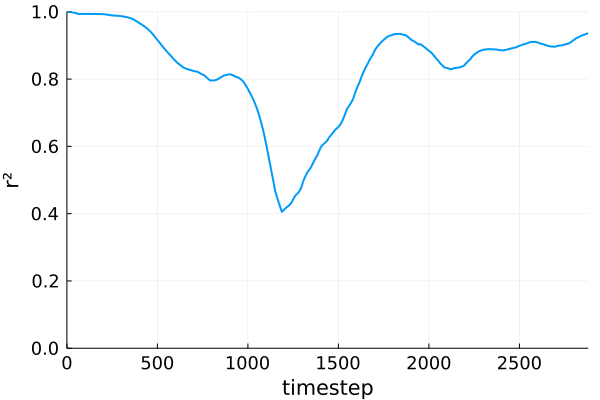

In [12]:
begin
    r2 = zeros(Float32, nstep)
    for i in 1:nstep
        r2[i] = Statistics.cor(A[:,1,i], scalar_GEOS_Array[:,i])^2
    end
    plot(Int(2880/nstep):Int(2880/nstep):2880, r2, width=2, label=false, xlabel="timestep", ylabel="r²", xlabelfontsize=14, ylabelfontsize=14,
        xtickfontsize=12, ytickfontsize=12, xlims=(0,2880), ylims=(0.0,1.0))
end
#savefig("r2_CNN_16X_100EPOCHS_VL_GEOS_JAN_2019.png")

In [ ]:
#writedlm( "CNN_DLR_100_2x8x_VL_GEOS_JAN_NASA_GMAO.csv", A, ',')
#@save "CNN_DLR_100EPOCHS_2X8X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model

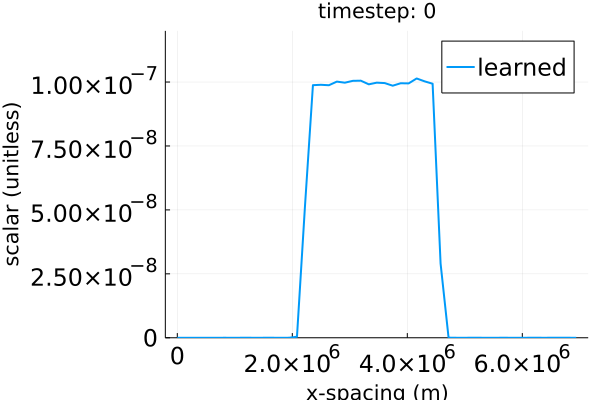

In [11]:
begin
    plot(0:34687.5*4:6937500, 1e-7*input_NN_integrate[:,1,1,1], label = "learned", title = string("timestep: ", string(4*1-4)), 
        xlabel="x-spacing (m)", ylabel="scalar (unitless)", xlabelfontsize=16, ylabelfontsize=16, 
        xtickfontsize=16, ytickfontsize=16, legendfontsize=16, width=2, ylims=(0.0, 1.2e-7))
end

In [27]:
begin
    plot(0:34687.5*4:6937500, A[:,1,1], label = "learned", title = string("time: ", string((round(1/720*10; digits = 1))), " days"), 
        xlabel="x-spacing (m)", ylabel="scalar (unitless)", titlefontsize=16, xlabelfontsize=16, ylabelfontsize=16, 
        xtickfontsize=14, ytickfontsize=14, legendfontsize=14, width=4, ylims=(0.0, 1.2e-7), margin=2Plots.mm)
    #, ylims=(0.0, 1.2e-7)
    plot!(0:34687.5*4:6937500, 1e-7*target_NN_integrate[:,1,1,1], label = "numerical", width=4)
end

savefig("plot.png")

In [45]:
begin
    plot(0:34687.5*16:6937500, A[:,1,44], title = string("time: ", string((round(44/45*10; digits = 1))), " days"), 
        xtick = false, ytick = false, legend = false, width=4.8, ylims=(0.0, 1.2e-7), titlefontsize=19)
    #, ylims=(0.0, 1.2e-7)
    plot!(0:34687.5*16:6937500, 1e-7*target_NN_integrate[:,1,1,44], xtick = false, ytick = false, legend = false, width=4)
end

savefig("plot.png")

In [ ]:
begin
    plot(0:34687.5:6937500, input_NN_integrate[:,1,1,1], label="t=0", width = 2, xlabel="x (unitless)", xlabelfontsize=14, ylabel="scalar (unitless)", ylabelfontsize=14, xtickfontsize = 12, ytickfontsize = 12, legend=:topleft, legendfontsize = 12)
    plot!(0:34687.5:6937500, input_NN_integrate[:,1,1,300], label="t=1", width = 2)
end

#savefig("plot.png")

┌ Info: Saved animation to 
│   fn = /projects/ctessum/manhop2/advect_NN/1D advection Conv wo physics 0-gradient/animation.gif
└ @ Plots /home/manhop2/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN/1D advection Conv wo physics 0-gradient/animation.gif")
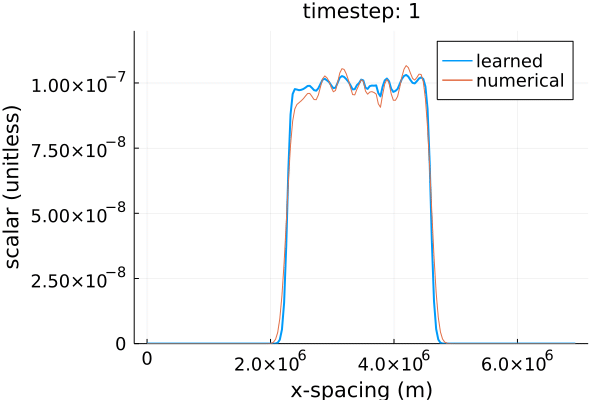

In [53]:
anim = @animate for i ∈ 1:nstep-1
    plot(0:34687.5*1:6937500, A[:,1,i], label = "learned", title = string("timestep: ", string(8*i-7)), 
        xlabel="x-spacing (m)", ylabel="scalar (unitless)", xlabelfontsize=14, ylabelfontsize=14, 
        xtickfontsize=12, ytickfontsize=12, legendfontsize=12, width=2, ylims=(0.0, 1.2e-7))
    #, ylims=(0.0, 1.2e-7)
    plot!(0:34687.5*1:6937500, 1e-7*target_NN_integrate[:,1,1,i], label = "numerical")
end
gif(anim, "animation.gif", fps = 16)

┌ Info: Saved animation to 
│   fn = /projects/ctessum/manhop2/advect_NN/1D advection Conv wo physics 0-gradient/animation.gif
└ @ Plots /home/manhop2/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN/1D advection Conv wo physics 0-gradient/animation.gif")
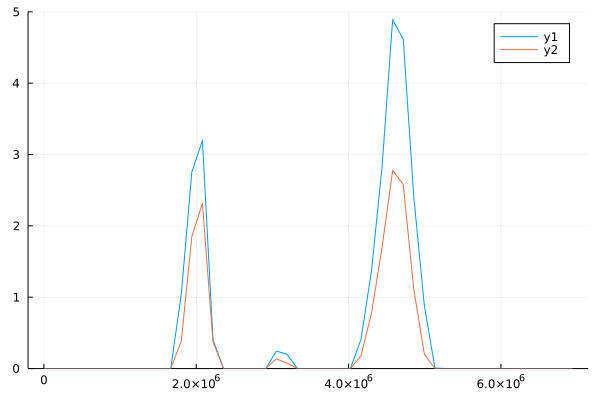

In [185]:
anim = @animate for i ∈ 1:179
    plot(0:34687.5*4:6937500, model(Data[i][1])[:,1], ylims=(0.0,5.0))
    plot!(0:34687.5*4:6937500, model(Data[i][1])[:,2])
end
gif(anim, "animation.gif", fps = 15)

In [ ]:
plot(0:34687.5:6937500, target_NN_integrate[:,1,1,1], label = "numerical")